# **Install Dependencies and Setup**





In [46]:
# Install dependencies
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

# Verify TensorFlow installation
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

# Set GPU memory growth to avoid OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs available:", tf.config.list_physical_devices('GPU'))


  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
TensorFlow version: 2.17.1
GPUs available: []


# **Unzip Dataset & Clean Dodgy Images**


In [54]:
import os
import cv2
import imghdr
import zipfile

# Unzip data.zip
zip_path = '/content/data.zip'  # Update this path as needed
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

data_dir = '/content/data'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']  # Valid image extensions

# Remove corrupted or invalid images
for image_class in os.listdir(data_dir):
    class_path = os.path.join(data_dir, image_class)
    if os.path.isdir(class_path):  # Ensure it's a directory
        for image in os.listdir(class_path):
            image_path = os.path.join(class_path, image)
            if os.path.isfile(image_path):  # Ensure it's a file
                try:
                    img = cv2.imread(image_path)
                    ext = imghdr.what(image_path)
                    if ext not in image_exts:
                        print(f"Deleting invalid image: {image_path}")
                        os.remove(image_path)
                except Exception as e:
                    print(f"Error with image {image_path}: {e}")
                    os.remove(image_path)


# **Load and Prepare Dataset**



In [53]:
import shutil

# Path to the directory you want to delete
dir_path = '/content/data'

# Delete the directory and all its contents
shutil.rmtree(dir_path)

In [55]:
# Load dataset
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(256, 256),
    batch_size=32,
    shuffle=True
)

# Split data into train, validation, and test sets
train_size = int(0.7 * len(data))
val_size = int(0.2 * len(data))
test_size = int(0.1 * len(data))

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

print(f"Train size: {train_size}, Val size: {val_size}, Test size: {test_size}")


Found 305 files belonging to 2 classes.
Train size: 7, Val size: 2, Test size: 1


# **Scale Data**

In [56]:
# Scale data
train = train.map(lambda x, y: (x / 255.0, y))
val = val.map(lambda x, y: (x / 255.0, y))
test = test.map(lambda x, y: (x / 255.0, y))


# **Build the Deep Learning Model**

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

# Define model
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),  # Prevent overfitting
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# **Train the Model**

In [58]:
# Set up TensorBoard callback
logdir = '/content/logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# Train model
hist = model.fit(
    train,
    epochs=20,
    validation_data=val,
    callbacks=[tensorboard_callback]
)


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.5247 - loss: 1.0436 - val_accuracy: 0.5312 - val_loss: 0.6397
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.6294 - loss: 0.6598 - val_accuracy: 0.5469 - val_loss: 0.6390
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.6853 - loss: 0.6143 - val_accuracy: 0.7969 - val_loss: 0.5895
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.8392 - loss: 0.5652 - val_accuracy: 0.9062 - val_loss: 0.4085
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.8252 - loss: 0.4089 - val_accuracy: 0.9062 - val_loss: 0.3899
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.8855 - loss: 0.3598 - val_accuracy: 0.9062 - val_loss: 0.2715
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.9050 - loss: 0.3001 - val_accuracy: 0.8281 - val_loss: 0.3186
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 0.8538 - loss: 0.2858 - val_accuracy: 0.9531 - val_loss: 0.2060
Epoch 9/

# **Plot Performance**

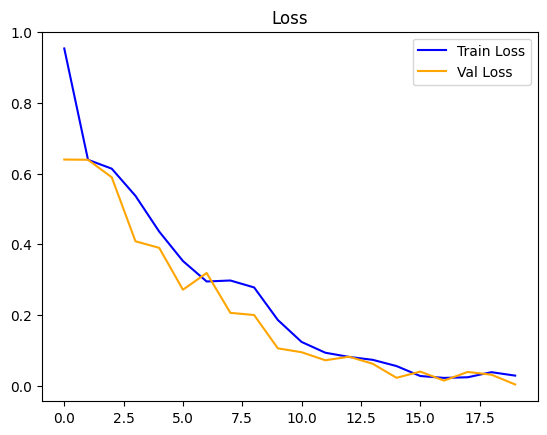

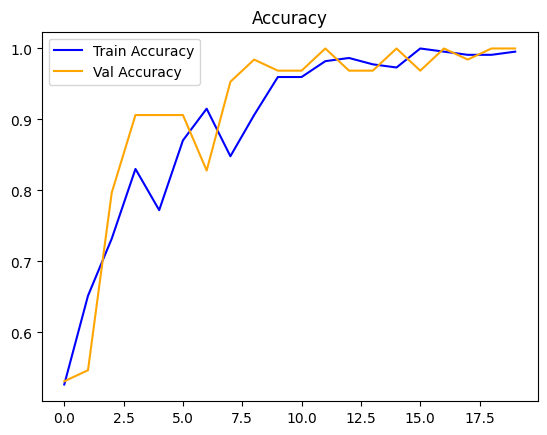

In [59]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure()
plt.plot(hist.history['loss'], label='Train Loss', color='blue')
plt.plot(hist.history['val_loss'], label='Val Loss', color='orange')
plt.title('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure()
plt.plot(hist.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(hist.history['val_accuracy'], label='Val Accuracy', color='orange')
plt.title('Accuracy')
plt.legend()
plt.show()


# **Evaluate the Model**

In [60]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

# Initialize metrics
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

# Evaluate on test set
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(f"Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
Precision: 1.0, Recall: 1.0, Accuracy: 1.0


# **Test on a Any Image**

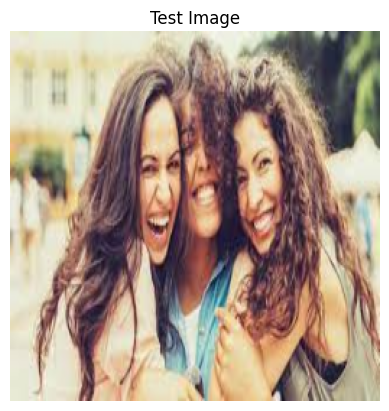

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Prediction array: [[0.00170084]]
Predicted class: Happy


In [75]:
import cv2
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

# Test image path
test_image_path = '/content/data/happy/image26.jpeg'  # Replace with an actual image path

# Load and preprocess image
img = cv2.imread(test_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
resize = tf.image.resize(img, (256, 256)) / 255.0  # Resize and normalize

# Plot the image
plt.imshow(resize.numpy())  # Plot the resized image
plt.title("Test Image")
plt.axis('off')
plt.show()

# Predict
yhat = model.predict(np.expand_dims(resize, axis=0))
print("Prediction array:", yhat)

# Display prediction result
if yhat > 0.5:
    print("Predicted class: Sad")
else:
    print("Predicted class: Happy")
